In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns

sns.set_context('poster')

import postprocessing

In [2]:
results = postprocessing.compute_results('./results_cuda_naive_with_overheads.csv')

In [3]:
results

{'bodies': array([1024]),
 'mean': [1.6401497333333335],
 'lower': [1.6397723357215264],
 'upper': [1.6405271309451406],
 'mean_over': [0.000704766666666649],
 'lower_over': [0.0005854503196199296],
 'upper_over': [0.0008240830137133683]}

In [3]:
fig_colors = [
        ('forestgreen', 'mediumseagreen'),  # 1024
        ('navy', 'lightskyblue'),  # 2048
        ('gold', 'blanchedalmond'),  # 4096
        ('firebrick', 'lightcoral'),  # 8192
]

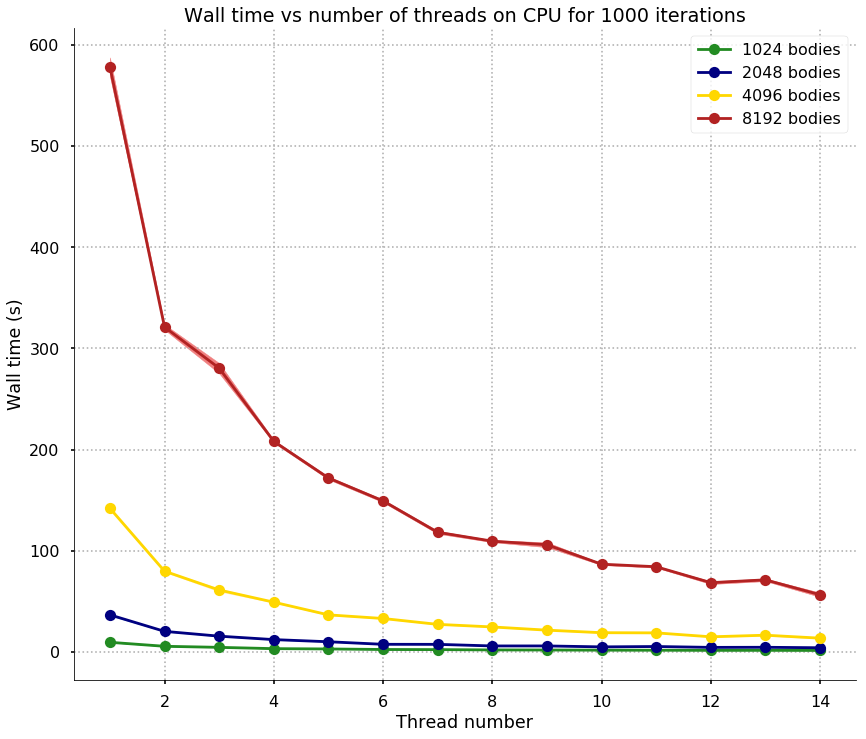

In [32]:
fig, ax = postprocessing.plot_complete(results, n_iter=1000, colors=fig_colors)
pl.grid(linestyle=":")
pl.savefig('./img/t_vs_threads.png', bbox_inches='tight', dpi=300)

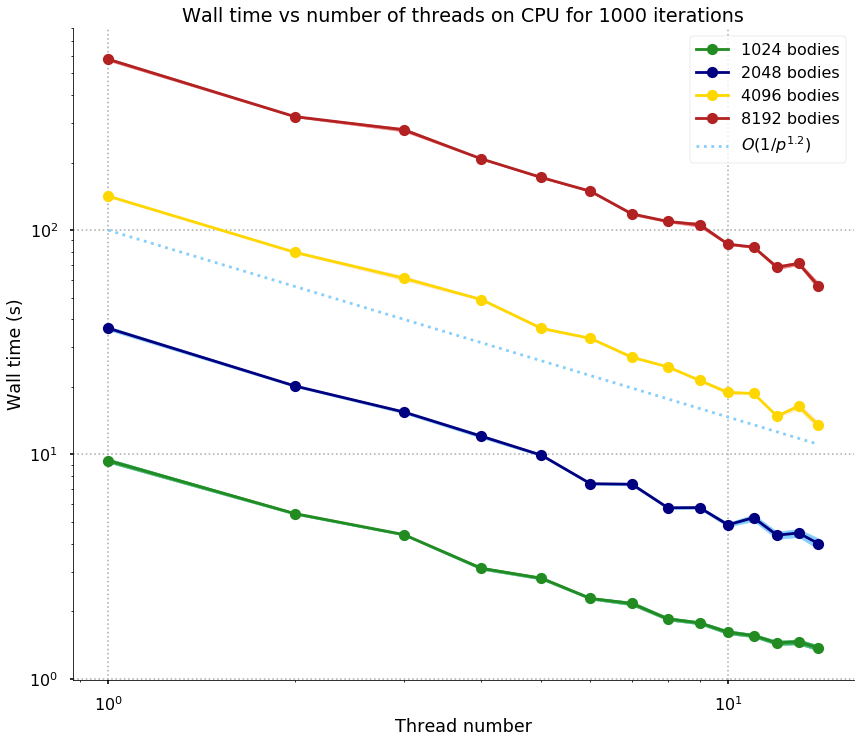

In [47]:
nt = np.array(results['threads'][0])
fig, ax = postprocessing.plot_complete(results, n_iter=1000, colors=fig_colors, logx=True, logy=True,
                                       asympt=100/np.power(nt, 1.0 / 1.2), asympt_color='lightskyblue',
                                       asympt_label=r'$O(1/p^{1.2})$')
pl.grid(linestyle=':')
pl.savefig('./img/t_vs_threads_log.png', bbox_inches='tight', dpi=300)

# Analisi matematica del problema

Calcoleremo:

- overhead totale $T_O = pT_p - T_s$
- speedup $S = \frac{T_s}{T_{tot}^{par}}$
- efficienza $E = \frac{S}{p}$ che dovrà essere $E \lt 1$ se il problema non è superlineare per effetto delle cache processore
- costo $C = T_{tot}^{par}p$

## Overhead totale

In [48]:
t_seriale = np.array([x[0] for x in results['mean']])
threads = results['threads']
media = results['mean']
d = dict()

for i, nb in enumerate(results['bodies']):
    tmp = dict()
    tmp['nt'] = threads[i]
    tmp['m'] = np.array(media[i])
    d[nb] = tmp

In [49]:
def calcola_t_overhead(threads, media):
    assert threads[0] == 1
    assert len(threads) == len(media)
    t_s = media[0]
    t_overhead = []
    
    for i, (p, t_p) in enumerate(zip(threads, media)):
        t_overhead.append((p * t_p) - t_s)
    
    return t_overhead

In [50]:
overhead = dict()

for nb in results['bodies']:
    print(f"N = {nb}")
    threads = d[nb]['nt']
    media = d[nb]['m']
    t_s = media[0]
    
    t_overhead = calcola_t_overhead(threads, media)
    overhead[nb] = dict()
    overhead[nb]['t_over'] = t_overhead[1:]
    overhead[nb]['nt'] = threads[1:]
    overhead[nb]['t_s'] = t_s
    
    
    print("Overhead rispetto a t_s = {:6.4f}".format(t_s))
    for i in range(1, len(t_overhead)):
        print("Con {} threads -> tempo di calcolo totale = {:6.4f}, overhead = {:6.4f} s".format(threads[i], media[i], t_overhead[i]))
    
    print("")

N = 1024
Overhead rispetto a t_s = 9.3891
Con 2 threads -> tempo di calcolo totale = 5.4471, overhead = 1.5051 s
Con 3 threads -> tempo di calcolo totale = 4.3897, overhead = 3.7801 s
Con 4 threads -> tempo di calcolo totale = 3.1054, overhead = 3.0327 s
Con 5 threads -> tempo di calcolo totale = 2.8049, overhead = 4.6355 s
Con 6 threads -> tempo di calcolo totale = 2.2799, overhead = 4.2902 s
Con 7 threads -> tempo di calcolo totale = 2.1638, overhead = 5.7577 s
Con 8 threads -> tempo di calcolo totale = 1.8483, overhead = 5.3975 s
Con 9 threads -> tempo di calcolo totale = 1.7739, overhead = 6.5760 s
Con 10 threads -> tempo di calcolo totale = 1.6117, overhead = 6.7278 s
Con 11 threads -> tempo di calcolo totale = 1.5569, overhead = 7.7371 s
Con 12 threads -> tempo di calcolo totale = 1.4439, overhead = 7.9373 s
Con 13 threads -> tempo di calcolo totale = 1.4596, overhead = 9.5860 s
Con 14 threads -> tempo di calcolo totale = 1.3714, overhead = 9.8103 s

N = 2048
Overhead rispetto a 

In [51]:
def plot_t_overhead(overhead, colors, logy=False, grid=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for nb in overhead:
        current = overhead[nb]
        
        t_over = current['t_over']
        n_threads = current['nt']
        t_s = current['t_s']
        
        color = colors[nb]
        
        ax.plot(n_threads, t_over, color=color, marker='o', label=f"{nb} bodies")
    
    ax.set_xlabel("p")
    ax.set_ylabel("Overhead time (s)")

    if logy:
        pl.yscale('log')
    
    pl.grid(grid, linestyle=":")

    pl.legend()
    sns.despine()

    return fig, ax

In [52]:
colors = {
    1024: 'forestgreen',
    2048: 'navy',
    4096: 'gold',
    8192: 'firebrick',
}

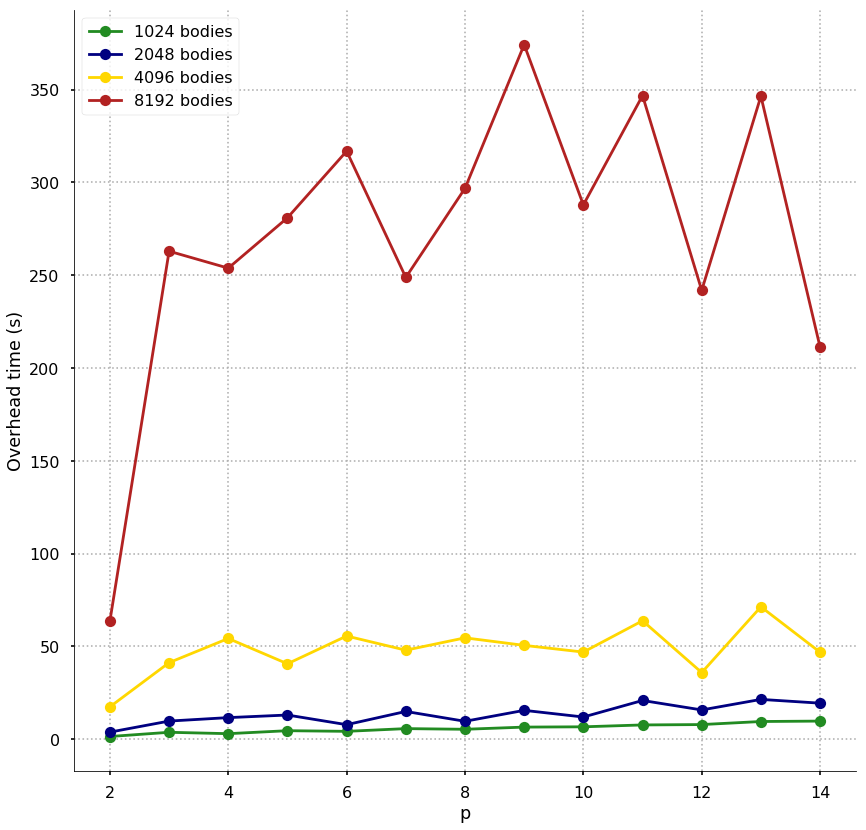

In [55]:
plot_t_overhead(overhead, colors=colors, grid=True, logy=False)
pl.savefig('./img/t_overhead.png', bbox_inches='tight', dpi=300)

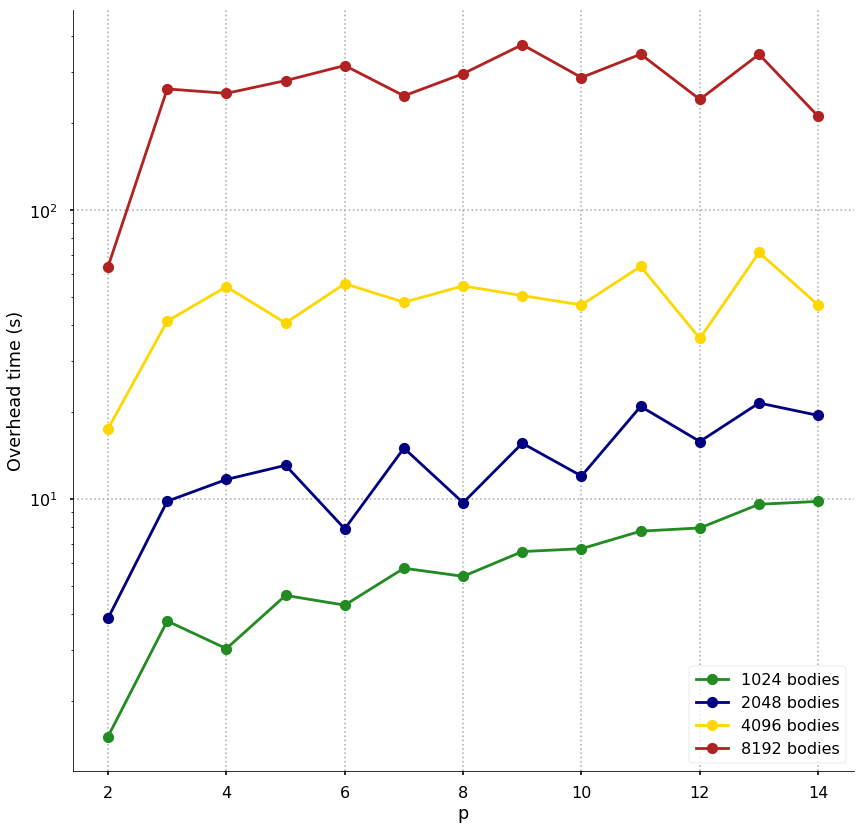

In [56]:
plot_t_overhead(overhead, colors=colors, logy=True)
pl.savefig('./img/t_overhead_log.png', bbox_inches='tight', dpi=300)

## Speedup

In [57]:
speedup = dict()

for nb in results['bodies']:
    print(f"N = {nb}")
    threads = np.array(d[nb]['nt'])
    media = np.array(d[nb]['m'])
    t_s = media[0]
    
    inc = t_s / media
    efficienza = inc / threads
    
    speedup[nb] = dict()
    speedup[nb]['speedup'] = inc[1:]
    speedup[nb]['nt'] = threads[1:]
    speedup[nb]['E'] = efficienza[1:]
    speedup[nb]['t_s'] = t_s
    
    print("Spedup rispetto a t_s = {:6.4f}".format(t_s))
    for i in range(1, len(inc)):
        print("Con {:2d} threads -> tempo totale = {:10.2f} s\t S = {:6.2f}\t E = {:4.2f} %".format(
            threads[i], media[i], inc[i], efficienza[i] * 100))
    
    print("")

N = 1024
Spedup rispetto a t_s = 9.3891
Con  2 threads -> tempo totale =       5.45 s	 S =   1.72	 E = 86.18 %
Con  3 threads -> tempo totale =       4.39 s	 S =   2.14	 E = 71.30 %
Con  4 threads -> tempo totale =       3.11 s	 S =   3.02	 E = 75.59 %
Con  5 threads -> tempo totale =       2.80 s	 S =   3.35	 E = 66.95 %
Con  6 threads -> tempo totale =       2.28 s	 S =   4.12	 E = 68.64 %
Con  7 threads -> tempo totale =       2.16 s	 S =   4.34	 E = 61.99 %
Con  8 threads -> tempo totale =       1.85 s	 S =   5.08	 E = 63.50 %
Con  9 threads -> tempo totale =       1.77 s	 S =   5.29	 E = 58.81 %
Con 10 threads -> tempo totale =       1.61 s	 S =   5.83	 E = 58.26 %
Con 11 threads -> tempo totale =       1.56 s	 S =   6.03	 E = 54.82 %
Con 12 threads -> tempo totale =       1.44 s	 S =   6.50	 E = 54.19 %
Con 13 threads -> tempo totale =       1.46 s	 S =   6.43	 E = 49.48 %
Con 14 threads -> tempo totale =       1.37 s	 S =   6.85	 E = 48.90 %

N = 2048
Spedup rispetto a t_s = 36.

In [69]:
def plot_speedup(S, colors, plot_linear=False, grid=False, logy=False, logx=False, same_axes=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for nb in S:
        current = S[nb]
        
        speedup = current['speedup']
        n_threads = current['nt']
        assert len(speedup) == len(n_threads)
        t_s = current['t_s']
        
        color = colors[nb]
        
        ax.plot(n_threads, speedup, color=color, marker='o', label=f"{nb} bodies")
    
    if plot_linear:
        ax.plot(n_threads, n_threads, linestyle=':', color='lightskyblue', label=r"speedup $\Theta(p)$")

    ax.set_xlabel("p")
    ax.set_ylabel("Speedup")
    
    ax.set_xlim(left=0, right=1.05 * max(n_threads))
    if same_axes:
        ax.set_ylim(bottom=0, top=1.05 * max(n_threads))
    else:
        ax.set_ylim(bottom=0, top=1.05 * max(speedup))

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()

    return fig, ax

User defined size is (14, 14)


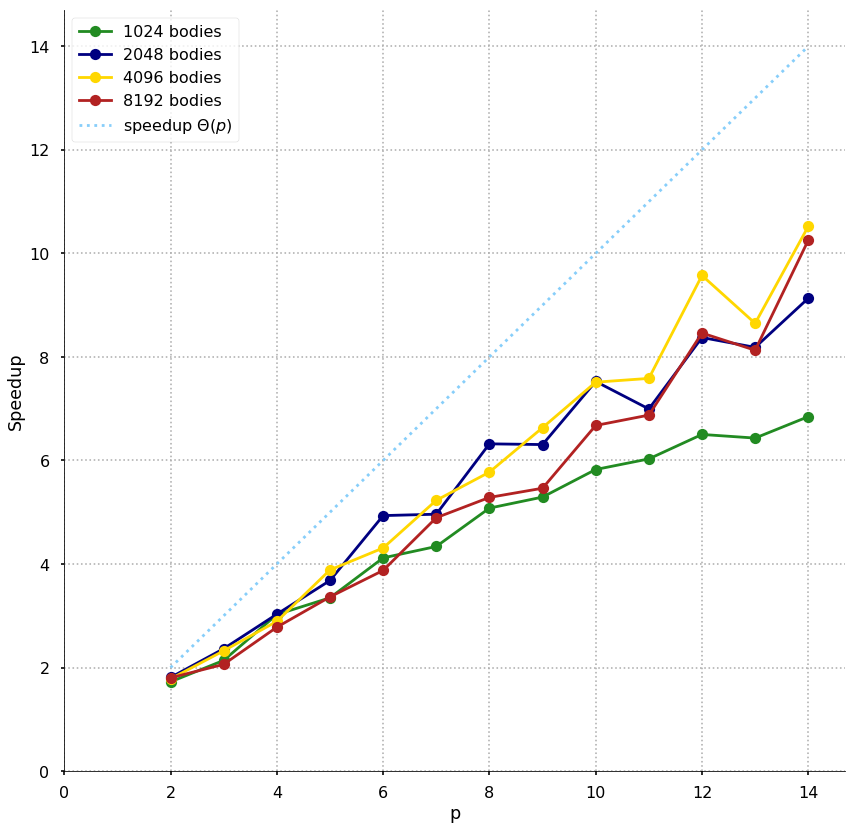

In [70]:
plot_speedup(speedup, colors, plot_linear=True, grid=True, logy=False, logx=False, same_axes=True, figsize=(14, 14))
pl.savefig('./img/speedup.png', bbox_inches='tight', dpi=300)

In [71]:
def plot_E(S, colors, grid=False, logy=False, logx=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for nb in S:
        current = S[nb]
        
        E = current['E']
        n_threads = current['nt']
        assert len(E) == len(n_threads)
        t_s = current['t_s']
        
        color = colors[nb]
        
        ax.plot(n_threads, E, color=color, marker='o', label=f"{nb} bodies")
    
    ax.set_xlabel("p")
    ax.set_ylabel("E")
    
    ax.set_xlim(left=0, right=1.05 * max(n_threads))
    ax.set_ylim(bottom=0, top=1.00)

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()

    return fig, ax

User defined size is (16, 12)


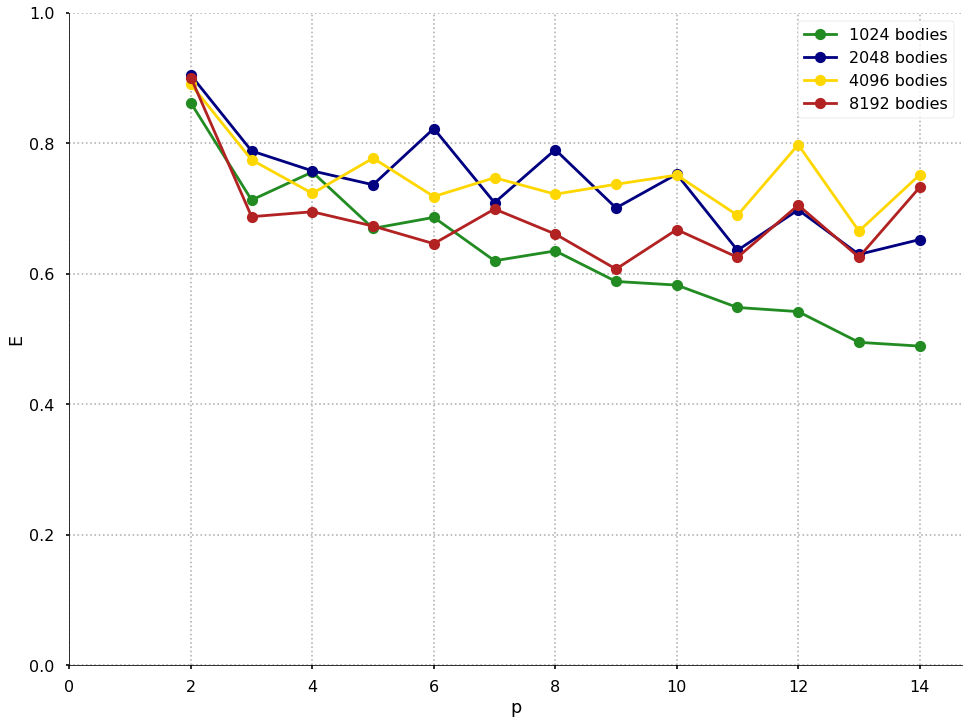

In [73]:
plot_E(speedup,
       colors,
       grid=True,
       logy=False,
       logx=False,
       figsize=(16, 12))
pl.savefig('./img/efficiency.png', bbox_inches='tight', dpi=300)

In [79]:
s = speedup[8192]['speedup']
for i, sp in enumerate(s):
    print("p = {:2d} \t S = {:5.2f}".format(i+2, sp))

p =  2 	 S =  1.80
p =  3 	 S =  2.06
p =  4 	 S =  2.78
p =  5 	 S =  3.37
p =  6 	 S =  3.88
p =  7 	 S =  4.89
p =  8 	 S =  5.29
p =  9 	 S =  5.46
p = 10 	 S =  6.68
p = 11 	 S =  6.88
p = 12 	 S =  8.46
p = 13 	 S =  8.13
p = 14 	 S = 10.25


## Costo

In [ ]:
def plot_costo(result, colors, grid=False, logy=False, logx=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)
    
    
    
    for nb in result:
        current = result[nb]
        
        t_tot = current['m']
        n_threads = current['nt']
        assert len(t_tot) == len(n_threads)

        costo = t_tot * n_threads
        
        color = colors[nb]
        
        ax.plot(n_threads, costo, color=color, marker='o', label=f"{nb} bodies")
    
    ax.set_xlabel("p")
    ax.set_ylabel("Cost")
    
#    ax.set_xlim(left=0, right=1.05 * max(n_threads))
#    ax.set_ylim(bottom=0, top=1.05 * max(costo))

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()
    
    try:
        filepath = kwargs['savefile']
        pl.savefig(filepath, bbox_inches='tight', dpi=300)
    except KeyError:
        pass

    return fig, ax

In [ ]:
d1 = dict()
for k in d:
    tmp = {
        'nt': d[k]['nt'][1:],
        'm': d[k]['m'][1:],
    }
    d1[k] = tmp

In [ ]:
plot_costo(d1, colors, grid=True, logx=False, logy=False, figsize=(14, 10))

In [ ]:
plot_costo(d1, colors, grid=True, logx=False, logy=True, figsize=(14, 10), savefile="./cost-logy.png")

# Benchmark algoritmo seriale

In ordine:

- tempo di esecuzione (wall time) vs N_body

In [ ]:
df = pd.read_csv('./results_static.csv')

In [ ]:
df.head()

In [ ]:
df['elapsed'] = df['end'] - df['start']

In [ ]:
df.head()

In [ ]:
data_tot = {
    'nb': [],
    'm': [],
    'l': [],
    'u': [],
}

for nb in np.unique(df['nbodies']):
    m, l, u = postprocessing.get_mean_ci(df[df['nbodies'] == nb].loc[:, 'elapsed'])
    data_tot['nb'].append(nb)
    data_tot['m'].append(m)
    data_tot['l'].append(l)
    data_tot['u'].append(u)

In [ ]:
print("Data for table in Google Documents:")
for i, n in enumerate(data_tot['nb']):
    print("N = {:6d} \t mean = {:8.2f} \t IC_width = {:4.2f}".format(
    n, data_tot['m'][i], (data_tot['m'][i] - data_tot['l'][i])))

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(14, 12))
nb = np.array(data_tot['nb'])
ax.plot(nb, data_tot['m'], color=fig_colors[0][0], marker='o', label="Mean")
ax.fill_between(nb, data_tot['l'], data_tot['u'], color=fig_colors[0][1], label="95% CI")

ax.set_xlabel("Number of bodies N")
ax.set_ylabel("Wall time (s)")
pl.xticks(nb, data_tot['nb'])
pl.title("Execution time vs N")
pl.legend(loc='upper left')

sns.despine()
pl.grid(linestyle=":")

pl.savefig("./img/t_serial.png", bbox_inches='tight', dpi=400)

pl.show()

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(14, 12))
nb = np.array(data_tot['nb'])
ax.plot(nb, data_tot['m'], color=fig_colors[0][0], marker='o', label="Mean")
ax.fill_between(nb, data_tot['l'], data_tot['u'], color=fig_colors[0][1], label="95% CI")

k1 = nb[0] / (nb[0] * nb[0]) * 0.0035
k2 = nb[0] / (nb[0] * nb[0]) * 0.0015

ax.plot(nb, k1 * nb * nb, color="lightskyblue", label="O(N^2)", linestyle=":")
ax.plot(nb, k2 * nb * nb, color="lightskyblue", linestyle=":")


ax.set_xlabel("Number of bodies N")
ax.set_ylabel("Wall time (s)")
pl.xticks(nb, data_tot['nb'])
pl.title("Execution time vs N (log scale)")
pl.legend(loc='upper left')
pl.xscale('log', basex=2)
pl.yscale('log')
sns.despine()
pl.grid(linestyle=":")

pl.savefig("./img/t_serial_log.png", bbox_inches='tight', dpi=400)
pl.show()